# Predictions after removing n channels

Edit the constants.py file, and correct the paths for `model` and `data` to `../model` and `../data`

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from path import Pathlib

import sys
sys.path.append("../")

from evaluate_script import read_data, predict

Keys in the HDF5 file: ['exam_id', 'tracings']


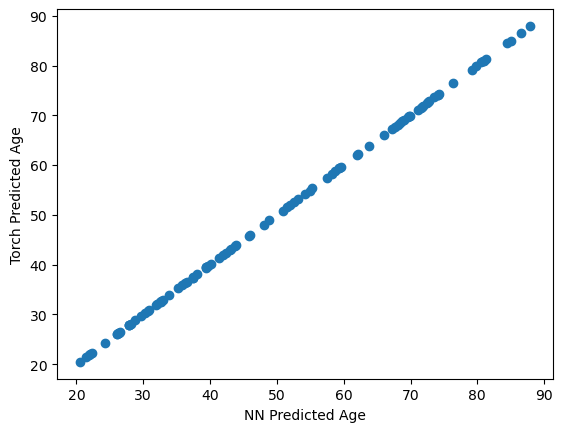

In [2]:
# to predict for the first 100 patients from the file 16
n_total = 100  # to use filters; use a positive number to use first n
batch_size = 20
data_array, df, exam_ids = read_data(n_total=100, data_file='../trace_file.npy')
predict(data_array, df, exam_ids, reconstruct=False, batch_size=batch_size)

In [3]:
df_out = pd.read_csv("../data/prediction.csv")
df_out.head()

,exam_id,age,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,patient_id,death,timey,normal_ecg,trace_file,torch_pred
0,1750214,82,False,67.269160,False,False,False,False,False,False,620960,NaN,NaN,False,exams_part16.hdf5,67.269196
1,1688724,44,False,40.132603,False,False,False,False,False,False,656803,NaN,NaN,True,exams_part16.hdf5,40.132620
2,1771393,51,False,55.314810,False,False,False,False,False,False,1096166,NaN,NaN,False,exams_part16.hdf5,55.314830
3,1793030,28,False,43.013763,False,False,False,False,False,False,1653247,NaN,NaN,False,exams_part16.hdf5,43.013676
4,1717689,52,True,80.612400,False,False,False,False,False,False,647834,NaN,NaN,False,exams_part16.hdf5,80.612380


In [4]:
data_array.shape

(100, 4096, 12)

In [5]:
(df_out['torch_pred'].notna()).sum()

np.int64(100)

# Remove one channel, replace with the average of the rest of the channels

In [6]:
data_array.shape

(100, 4096, 12)

### How to take mean for a channel in between

Set that channel to nan
Use np.nanmean

In [7]:
trace = data_array[:1, :, :]
trace.shape

(1, 4096, 12)

In [8]:
trace[:, :, 0] = np.nan
trace0_mean = np.nanmean(trace[:, :, :], axis=2)

In [9]:
subject0_mean = np.mean(data_array[:1, :, 1:], axis=2)
(abs(trace0_mean - subject0_mean)).max()

np.float32(1.1920929e-07)

<Axes: >

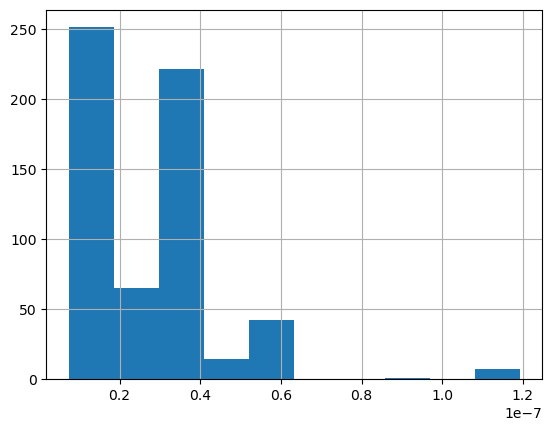

In [13]:
# Mostly the difference is 0. If not, it's ~ 10e-07; much smaller than the recorded voltages
diff = pd.Series(abs(trace0_mean - subject0_mean)[0, :])
diff[diff > 0].hist()

In [37]:
n_chan = 1

outdir = "../data/n_chan_removal"
Path(outdir).mkdir(parents=True, exist_ok=True)

for chan in range(12):
    data_array_chan = data_array.copy()
    # replace the channel with nan
    data_array_chan[:, :, chan] = np.nan
    # replace the nans with the nanmean, take mean only for the channel axis
    data_array_chan[:, :, chan] = np.nanmean(data_array_chan, axis=2)
    # predict
    predict(
        data_array_chan,
        df,
        exam_ids,
        reconstruct=False,
        batch_size=batch_size,
        outfile=f"{outdir}/prediction_chan{chan}.csv",
        keep_orig_cols=False,
    )

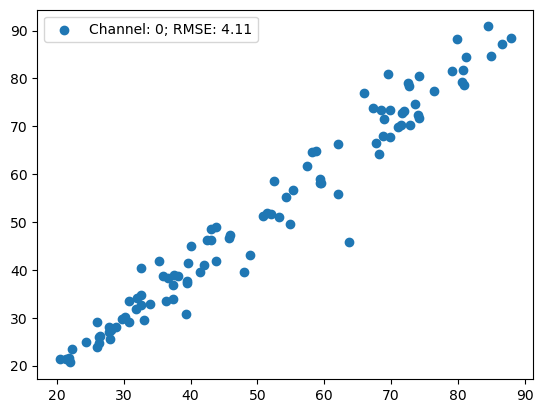

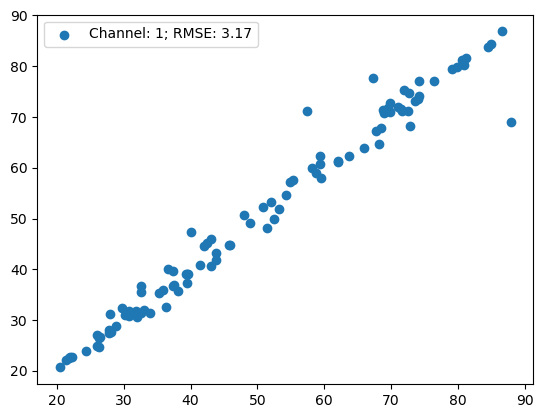

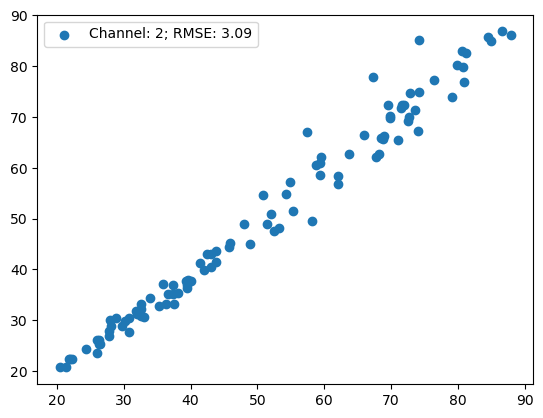

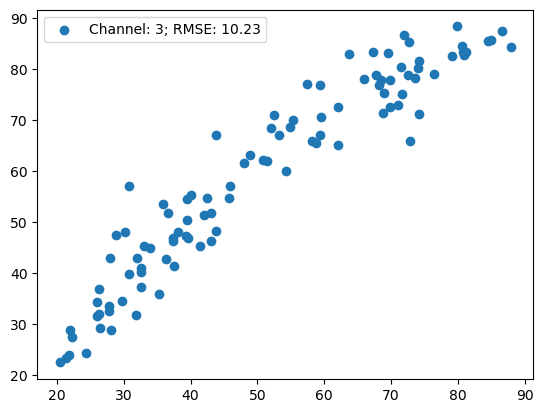

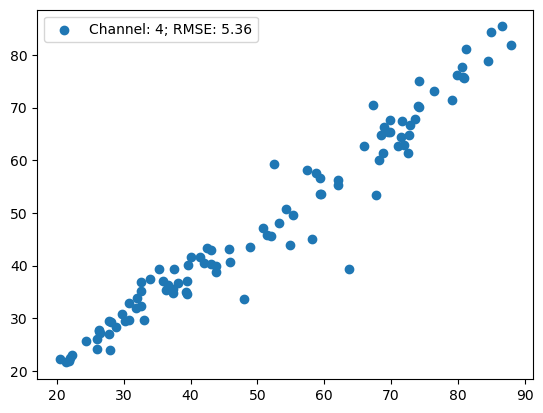

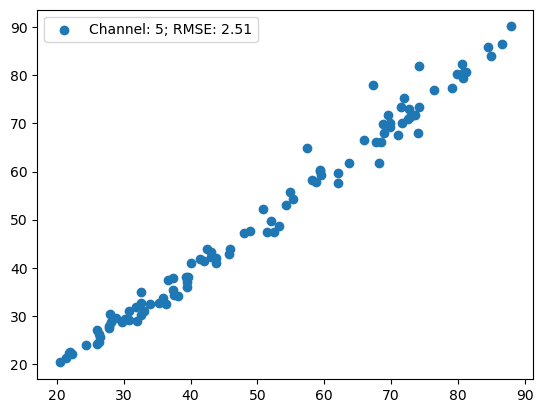

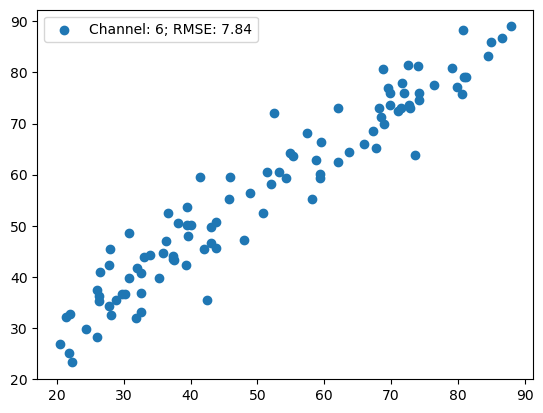

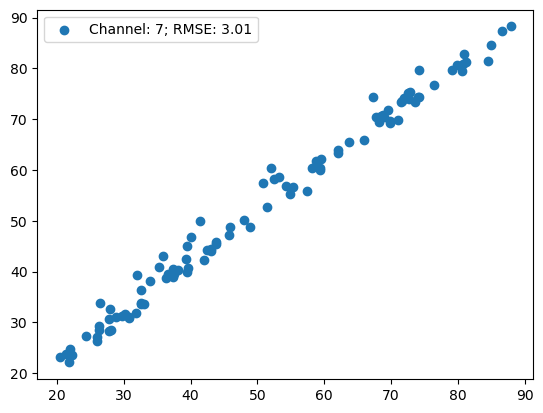

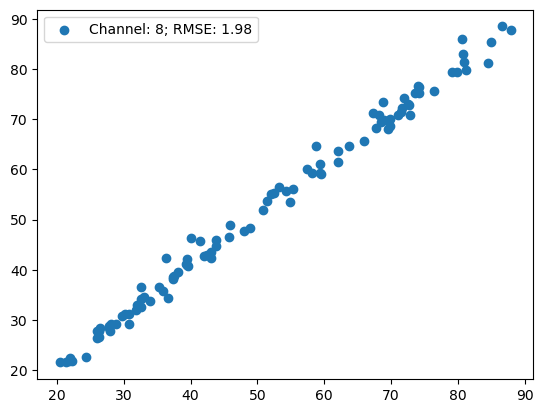

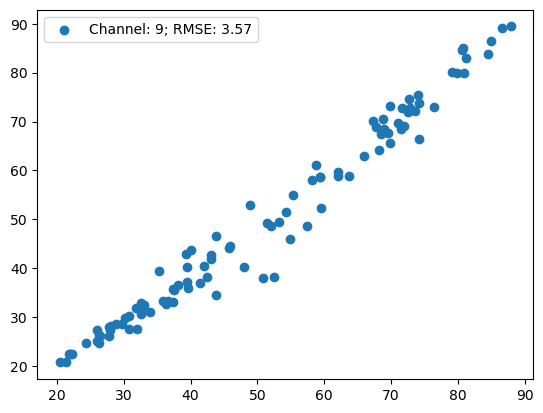

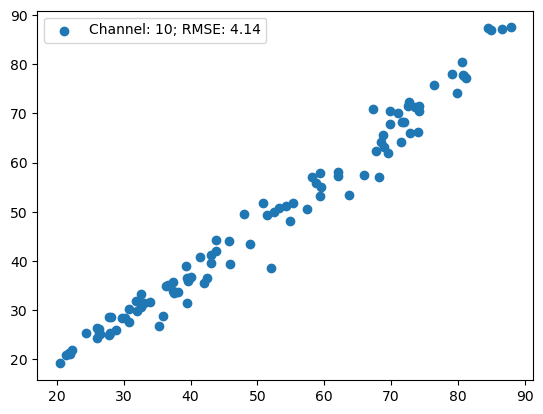

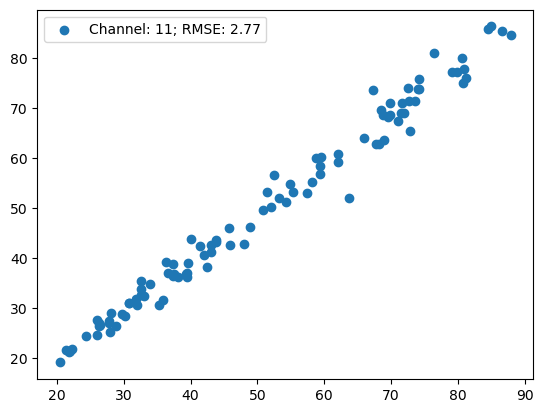

In [41]:
from sklearn.metrics import root_mean_squared_error
for chan in range(12):
    df_c = pd.read_csv(f"{outdir}/prediction_chan{chan}.csv")
    df_c = df_c.merge(
        df[['exam_id', 'nn_predicted_age']],
        on='exam_id',
    )
    rmse = round(root_mean_squared_error(df_c['nn_predicted_age'], df_c['torch_pred']), 2)
    plt.scatter(df_c['nn_predicted_age'], df_c['torch_pred'], label=f"Channel: {chan}; RMSE: {rmse}")
    plt.legend()
    plt.show()